In [11]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix


In [12]:
df = pd.read_csv("train_df.csv")   # change filename if needed

df.head()


,id,review,label,division
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative


In [13]:
print("Shape:", df.shape)
print(df.columns)

# Drop index column (if present)
df = df.drop(columns=[df.columns[0]])

# Keep only review and result
df = df[['review', 'division']]

df.head()

Shape: (31232, 4)
Index(['id', 'review', 'label', 'division'], dtype='object')


,review,division
0,"Cooking microwave pizzas, yummy",positive
1,Any plans of allowing sub tasks to show up in ...,neutral
2,"I love the humor, I just reworded it. Like sa...",positive
3,naw idk what ur talkin about,neutral
4,That sucks to hear. I hate days like that,negative


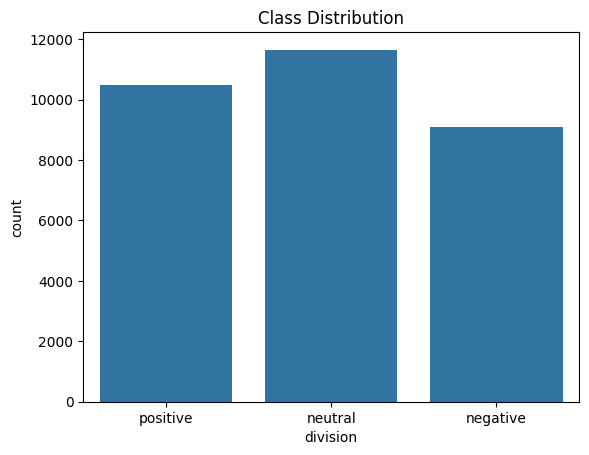

In [14]:
sns.countplot(x='division', data=df)
plt.title("Class Distribution")
plt.show()

In [15]:
label_encoder = LabelEncoder()
df['result'] = label_encoder.fit_transform(df['division'])

print(label_encoder.classes_)

df.head()

['negative' 'neutral' 'positive']


,review,division,result
0,"Cooking microwave pizzas, yummy",positive,2
1,Any plans of allowing sub tasks to show up in ...,neutral,1
2,"I love the humor, I just reworded it. Like sa...",positive,2
3,naw idk what ur talkin about,neutral,1
4,That sucks to hear. I hate days like that,negative,0


In [16]:
y = to_categorical(df['result'])
y

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], shape=(31232, 3))

**Text Tokenization**

In [17]:
MAX_WORDS = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['review'])

sequences = tokenizer.texts_to_sequences(df['review'])
X = pad_sequences(sequences, maxlen=MAX_LEN)
X

array([[   0,    0,    0, ..., 8640, 5778, 1286],
       [   0,    0,    0, ...,   14,    4,  162],
       [   0,    0,    0, ...,    8,   75,  715],
       ...,
       [   0,    0,    0, ...,    0,    0,  632],
       [   0,    0,    0, ...,  559,   12,  274],
       [   0,    0,    0, ...,  382,    4,  355]],
      shape=(31232, 100), dtype=int32)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (24985, 100)
Testing shape: (6247, 100)


*Building ANN Model*

In [19]:
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=MAX_WORDS, output_dim=64, input_length=MAX_LEN))

# Convert 2D to 1D
model.add(Flatten())

# Hidden Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output Layer (3 classes)
model.add(Dense(3, activation='softmax'))

model.summary()

d:\Works\ML\ml-env\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5015 - loss: 0.9634 - val_accuracy: 0.6446 - val_loss: 0.8025
Epoch 2/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7151 - loss: 0.6761 - val_accuracy: 0.6534 - val_loss: 0.8162
Epoch 3/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8436 - loss: 0.4183 - val_accuracy: 0.6217 - val_loss: 0.9773
Epoch 4/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9178 - loss: 0.2289 - val_accuracy: 0.6131 - val_loss: 1.4057
Epoch 5/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9509 - loss: 0.1410 - val_accuracy: 0.6094 - val_loss: 1.6964
Epoch 6/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9658 - loss: 0.1032 - val_accuracy: 0.6054 - val_loss: 1.9604
Epoch 7/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9712 - loss: 0.0833 - val_accuracy: 0.6073 - val_loss: 2.2365
Epoch 8/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.9766 - loss: 0.0690 - 

***Plot Accuracy & Loss***

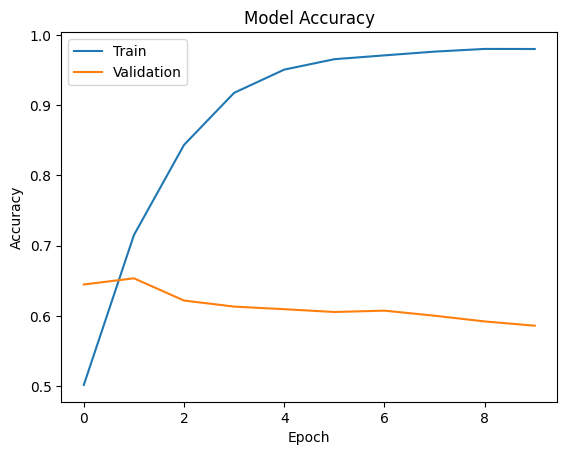

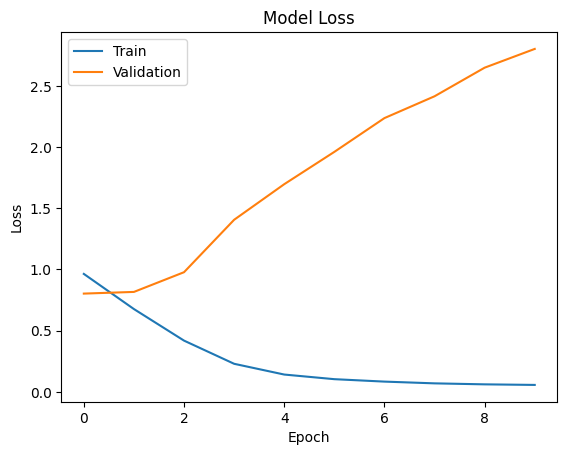

In [22]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [23]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5859 - loss: 2.8018
Test Accuracy: 0.585881233215332


***Confusion Matrix***

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


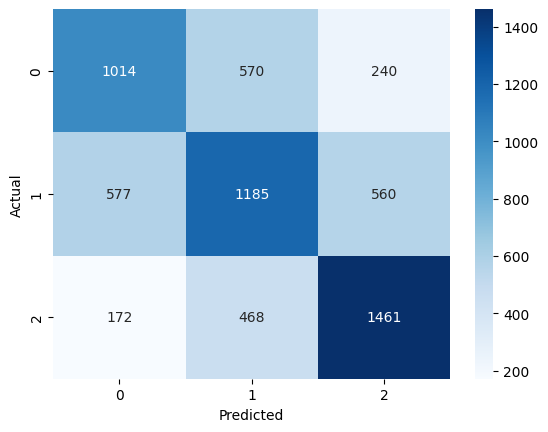

              precision    recall  f1-score   support

           0       0.58      0.56      0.57      1824
           1       0.53      0.51      0.52      2322
           2       0.65      0.70      0.67      2101

    accuracy                           0.59      6247
   macro avg       0.58      0.59      0.59      6247
weighted avg       0.58      0.59      0.58      6247



In [24]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_true, y_pred_classes))

**Testing Custom Review**

In [25]:
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_LEN)
    prediction = model.predict(padded)
    label = label_encoder.inverse_transform([np.argmax(prediction)])
    return label[0]

# Try
print(predict_sentiment("This movie was absolutely fantastic!"))
print(predict_sentiment("Worst experience ever."))
print(predict_sentiment("Nothing special, just a random movie."))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
neutral
